In [1]:
from utils import validate_env, setup_env, log_env
import os
import sys
from pyspark import SparkConf
from pyspark.sql import SparkSession

setup_env()
validate_env()
log_env()

SPARK_HOME = /root/uni-projects/bdm2/.venv/lib/python3.10/site-packages/pyspark
JAVA_HOME = /root/.sdkman/candidates/java/current
PATH = /root/uni-projects/bdm2/.venv/lib/python3.10/site-packages/pyspark/bin:/root/uni-projects/bdm2/.venv/bin:/root/.vscode-server/bin/dc96b837cf6bb4af9cd736aa3af08cf8279f7685/bin/remote-cli:/root/.tfenv/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/usr/lib/wsl/lib:/mnt/c/Users/Akos Schneider/.jdks/oracle-8/bin:/mnt/c/Program Files/Common Files/Oracle/Java/javapath:/mnt/c/Program Files (x86)/Common Files/Oracle/Java/javapath:/mnt/c/WINDOWS/system32:/mnt/c/WINDOWS:/mnt/c/WINDOWS/System32/Wbem:/mnt/c/WINDOWS/System32/WindowsPowerShell/v1.0/:/mnt/c/WINDOWS/System32/OpenSSH/:/mnt/c/Program Files (x86)/NVIDIA Corporation/PhysX/Common:/mnt/c/Program Files/Git/cmd:/mnt/c/Program Files/TortoiseGit/bin:/mnt/c/Users/Akos Schneider/apache-maven-3.8.6/bin:/mnt/c/Program Files/nodejs/:/mnt/c/ProgramData/chocolatey/bin:/mn

In [2]:
spark = None

In [3]:
if spark:
    spark.stop()
# Create the configuration in the local machine and give a name to the application
conf = SparkConf() \
    .set("spark.master", "local") \
    .set("spark.app.name", "Spark Dataframes Tutorial") \
    .set("spark.jars.packages", "org.apache.spark:spark-avro_2.12:3.5.1,org.mongodb.spark:mongo-spark-connector_2.12:10.3.0")


# Create the session 
spark = SparkSession.builder \
    .config(conf=conf) \
    .config("spark.mongodb.read.connection.uri", "mongodb://127.0.0.1:27017/") \
    .config("spark.mongodb.write.connection.uri", "mongodb://127.0.0.1:27017/") \
    .getOrCreate()
print(f"Python version = {spark.sparkContext.pythonVer}")
print(f"Spark version = {spark.version}")
print(spark.sparkContext.getConf().getAll())

your 131072x1 screen size is bogus. expect trouble
24/05/16 16:24:30 WARN Utils: Your hostname, akos-sch resolves to a loopback address: 127.0.1.1; using 172.23.175.226 instead (on interface eth0)
24/05/16 16:24:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/root/uni-projects/bdm2/.venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.spark#spark-avro_2.12 added as a dependency
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2ffab709-be25-4bb8-b6a4-8c438572f557;1.0
	confs: [default]
	found org.apache.spark#spark-avro_2.12;3.5.1 in central
	found org.tukaani#xz;1.9 in central
	found org.mongodb.spark#mongo-spark-connector_2.12;10.3.0 in central
	found org.mongodb#mongodb-driver-sync;4.8.2 in central
	[4.8.2] org.mongodb#mongodb-driver-sync;[4.8.1,4.8.99)
	found org.mongodb#bson;4.8.2 in central
	found org.mongodb#mongodb-driver-core;4.8.2 in central
	found org.mongodb#bson-record-codec;4.8.2 in central
:: resolution report :: resolve 2558ms :: artifacts dl 6ms
	:: modules in use:
	org.apache.spark#spark-avro_2.12;3.5.1 from central in [default]
	org.mongodb#bson;4.8.2 from central in [default]
	org.mongodb#bson-record-codec;4.

Python version = 3.10
Spark version = 3.5.1
[('spark.master', 'local'), ('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'), ('spark.submit.pyFiles', '/root/.i

## Income

In [4]:
income_dir = "../data/persistent-landing-zone/opendatabcn/income"
# get files
files = os.listdir(income_dir)
# keep only those that start with a year (4 digits)
files = [file for file in files if file[:4].isdigit()]
years = [file[:4] for file in files]
# add the path to the files
files = [f"{income_dir}/{file}" for file in files]
# create a list of dataframes
income_dfs = {}
for file, year in zip(files, years):
    # read the file
    df = spark.read.format("avro").load(file)
    # append the dataframe to the list
    income_dfs[year] = df

### Schema alignment

In [5]:
# change all column names to lowercase
for year in income_dfs:
    df = income_dfs[year]
    for col in df.columns:
        df = df.withColumnRenamed(col, col.lower())
    income_dfs[year] = df

In [6]:
checked_pairs = []
# check pairwise schema equality
for year1 in income_dfs:
    for year2 in income_dfs:
        if year1 != year2 and income_dfs[year1].schema != income_dfs[year2].schema and (year1, year2) not in checked_pairs:
            checked_pairs.append((year1, year2))
            checked_pairs.append((year2, year1))
            print(f"Schema of {year1} is different from schema of {year2}")
            # print the diff
            schema1 = income_dfs[year1].schema
            schema2 = income_dfs[year2].schema

            for field1, field2 in zip(schema1, schema2):
                if field1 != field2:
                    print(f"{field1.name} != {field2.name}")
                    print(f"{field1.dataType} != {field2.dataType}")
                    print(f"{field1.nullable} != {field2.nullable}")
                    print(f"{field1.metadata} != {field2.metadata}")
                    print("\n")



Schema of 2013 is different from schema of 2008
índex rfd barcelona = 100 != índex rfd barcelona = 100
StringType() != DoubleType()
True != True
{} != {}


Schema of 2013 is different from schema of 2017
índex rfd barcelona = 100 != índex rfd barcelona = 100
StringType() != DoubleType()
True != True
{} != {}


Schema of 2013 is different from schema of 2016
índex rfd barcelona = 100 != índex rfd barcelona = 100
StringType() != DoubleType()
True != True
{} != {}


Schema of 2008 is different from schema of 2012
índex rfd barcelona = 100 != índex rfd barcelona = 100
DoubleType() != StringType()
True != True
{} != {}


Schema of 2008 is different from schema of 2014
índex rfd barcelona = 100 != índex rfd barcelona = 100
DoubleType() != StringType()
True != True
{} != {}


Schema of 2008 is different from schema of 2011
índex rfd barcelona = 100 != índex rfd barcelona = 100
DoubleType() != StringType()
True != True
{} != {}


Schema of 2008 is different from schema of 2015
índex rfd barcel

In [7]:
income_dfs['2008'].head(5)

[Row(any=2008, codi_districte=1, nom_districte='Ciutat Vella', codi_barri=1, nom_barri='el Raval', població=47431, índex rfd barcelona = 100=62.6),
 Row(any=2008, codi_districte=1, nom_districte='Ciutat Vella', codi_barri=2, nom_barri='el Barri Gòtic', població=25556, índex rfd barcelona = 100=80.8),
 Row(any=2008, codi_districte=1, nom_districte='Ciutat Vella', codi_barri=3, nom_barri='la Barceloneta', població=16000, índex rfd barcelona = 100=65.9),
 Row(any=2008, codi_districte=1, nom_districte='Ciutat Vella', codi_barri=4, nom_barri='Sant Pere, Santa Caterina i la Ribera', població=22649, índex rfd barcelona = 100=81.8),
 Row(any=2008, codi_districte=2, nom_districte='Eixample', codi_barri=5, nom_barri='el Fort Pienc', població=32167, índex rfd barcelona = 100=108.3)]

In the next one, it is string.

In [8]:
income_dfs['2013'].head(5)

[Row(any=2013, codi_districte=1, nom_districte='Ciutat Vella', codi_barri=1, nom_barri='el Raval', població=49225, índex rfd barcelona = 100='60.3'),
 Row(any=2013, codi_districte=1, nom_districte='Ciutat Vella', codi_barri=2, nom_barri='el Barri Gòtic', població=16327, índex rfd barcelona = 100='103.6'),
 Row(any=2013, codi_districte=1, nom_districte='Ciutat Vella', codi_barri=3, nom_barri='la Barceloneta', població=15571, índex rfd barcelona = 100='82.1'),
 Row(any=2013, codi_districte=1, nom_districte='Ciutat Vella', codi_barri=4, nom_barri='Sant Pere, Santa Caterina i la Ribera', població=22821, índex rfd barcelona = 100='91.2'),
 Row(any=2013, codi_districte=2, nom_districte='Eixample', codi_barri=5, nom_barri='el Fort Pienc', població=31754, índex rfd barcelona = 100='99.0')]

In [9]:
# count the number of non float like values in the column
from pyspark.sql.types import StringType

for year in income_dfs:
    # if the 'índex rfd barcelona = 100' column is of type string
    if income_dfs[year].schema['índex rfd barcelona = 100'].dataType == StringType():
        # count the number of non float like values
        print(f"Year {year} has {income_dfs[year].filter(income_dfs[year]['índex rfd barcelona = 100'].rlike('[^0-9.]')).count()} non float like values in the 'índex rfd barcelona = 100' column")
        print(f"The values are:")
        income_dfs[year].filter(income_dfs[year]['índex rfd barcelona = 100'].rlike('[^0-9.]')).show()

Year 2013 has 1 non float like values in the 'índex rfd barcelona = 100' column
The values are:
+----+--------------+-------------+----------+---------+--------+-------------------------+
| any|codi_districte|nom_districte|codi_barri|nom_barri|població|índex rfd barcelona = 100|
+----+--------------+-------------+----------+---------+--------+-------------------------+
|2013|            99|    No consta|        99|No consta|     205|                        -|
+----+--------------+-------------+----------+---------+--------+-------------------------+

Year 2012 has 1 non float like values in the 'índex rfd barcelona = 100' column
The values are:
+----+--------------+-------------+----------+---------+--------+-------------------------+
| any|codi_districte|nom_districte|codi_barri|nom_barri|població|índex rfd barcelona = 100|
+----+--------------+-------------+----------+---------+--------+-------------------------+
|2012|            99|    No consta|        99|No consta|     145|      

In [10]:
income_dfs['2012'].groupBy('codi_districte').count().show()

+--------------+-----+
|codi_districte|count|
+--------------+-----+
|             1|    4|
|             6|    5|
|             3|    8|
|             5|    6|
|             9|    7|
|             4|    3|
|             8|   13|
|             7|   11|
|            10|   10|
|             2|    6|
|            99|    1|
+--------------+-----+



10 districts

In [11]:
# descending
income_dfs['2012'].select('codi_barri').distinct().sort('codi_barri', ascending=False).show()

+----------+
|codi_barri|
+----------+
|        99|
|        73|
|        72|
|        71|
|        70|
|        69|
|        68|
|        67|
|        66|
|        65|
|        64|
|        63|
|        62|
|        61|
|        60|
|        59|
|        58|
|        57|
|        56|
|        55|
+----------+
only showing top 20 rows



73 neighborhoods

In [12]:
# filter out from all dfs where codi_districte is not in the range of 1 and 10, and codi_barri is not in the range of 1 and 73
for year in income_dfs:
    df = income_dfs[year]
    df = df.filter(df['codi_districte'].between(1, 10) & df['codi_barri'].between(1, 73))
    income_dfs[year] = df

In [13]:
# count the number of non float like values in the column
from pyspark.sql.types import StringType

for year in income_dfs:
    # if the 'índex rfd barcelona = 100' column is of type string
    if income_dfs[year].schema['índex rfd barcelona = 100'].dataType == StringType():
        # count the number of non float like values
        print(f"Year {year} has {income_dfs[year].filter(income_dfs[year]['índex rfd barcelona = 100'].rlike('[^0-9.]')).count()} non float like values in the 'índex rfd barcelona = 100' column")
        print(f"The values are:")
        income_dfs[year].filter(income_dfs[year]['índex rfd barcelona = 100'].rlike('[^0-9.]')).show()

Year 2013 has 0 non float like values in the 'índex rfd barcelona = 100' column
The values are:
+---+--------------+-------------+----------+---------+--------+-------------------------+
|any|codi_districte|nom_districte|codi_barri|nom_barri|població|índex rfd barcelona = 100|
+---+--------------+-------------+----------+---------+--------+-------------------------+
+---+--------------+-------------+----------+---------+--------+-------------------------+

Year 2012 has 0 non float like values in the 'índex rfd barcelona = 100' column
The values are:
+---+--------------+-------------+----------+---------+--------+-------------------------+
|any|codi_districte|nom_districte|codi_barri|nom_barri|població|índex rfd barcelona = 100|
+---+--------------+-------------+----------+---------+--------+-------------------------+
+---+--------------+-------------+----------+---------+--------+-------------------------+

Year 2014 has 0 non float like values in the 'índex rfd barcelona = 100' colum

In [14]:
# create a udf to convert the string to a type double, given a value of string '60.3' it will return 60.3
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col

def str_to_double(value):
    converted = None
    try:
        converted = float(value)
    except:
        converted = None
    return converted

str_to_double_udf = udf(str_to_double, DoubleType())

In [15]:
# apply the udf to the column named 'índex rfd barcelona = 100'
for year in income_dfs:
    income_dfs[year] = income_dfs[year].withColumn('índex rfd barcelona = 100', str_to_double_udf(col('índex rfd barcelona = 100')))

In [16]:
checked_pairs = []
# check pairwise schema equality
for year1 in income_dfs:
    for year2 in income_dfs:
        if year1 != year2 and income_dfs[year1].schema != income_dfs[year2].schema and (year1, year2) not in checked_pairs:
            checked_pairs.append((year1, year2))
            checked_pairs.append((year2, year1))
            print(f"Schema of {year1} is different from schema of {year2}")
            # print the diff
            schema1 = income_dfs[year1].schema
            schema2 = income_dfs[year2].schema

            for field1, field2 in zip(schema1, schema2):
                if field1 != field2:
                    print(f"{field1.name} != {field2.name}")
                    print(f"{field1.dataType} != {field2.dataType}")
                    print(f"{field1.nullable} != {field2.nullable}")
                    print(f"{field1.metadata} != {field2.metadata}")
                    print("\n")


Issue resolved.

In [17]:
# print if the year corresponding in the dictionary and any row in the any field does not match
for year in income_dfs:
    df_year = income_dfs[year]
    # filter rows where any field is not equal to the year
    print(f"Rows before filtering in year {year}: {df_year.count()}")
    df_year = df_year.filter(~(df_year['any'] != year))
    print(f"Rows after filtering in year {year}: {df_year.count()}")
    income_dfs[year] = df_year

Rows before filtering in year 2013: 73
Rows after filtering in year 2013: 73
Rows before filtering in year 2008: 73
Rows after filtering in year 2008: 73
Rows before filtering in year 2012: 73
Rows after filtering in year 2012: 73
Rows before filtering in year 2014: 73
Rows after filtering in year 2014: 73
Rows before filtering in year 2011: 73
Rows after filtering in year 2011: 73
Rows before filtering in year 2015: 73
Rows after filtering in year 2015: 73
Rows before filtering in year 2017: 73
Rows after filtering in year 2017: 73
Rows before filtering in year 2016: 73
Rows after filtering in year 2016: 73
Rows before filtering in year 2009: 73
Rows after filtering in year 2009: 73
Rows before filtering in year 2007: 73
Rows after filtering in year 2007: 73
Rows before filtering in year 2010: 73
Rows after filtering in year 2010: 73


In [18]:
# merge all the dataframes into a single dataframe
income_df = None
for year in income_dfs:
    if income_df is None:
        income_df = income_dfs[year]
    else:
        income_df = income_df.union(income_dfs[year])

In [19]:
sum = 0
for year in income_dfs:
    print(income_dfs[year].count())
    sum += income_dfs[year].count()
print("Sum:", sum)

73
73
73
73
73
73
73
73
73
73
73
Sum: 803


In [20]:
income_df.count()

803

### Deduplication

In [21]:
# deduplicate the dataframe
print(f"Number of rows before deduplication: {income_df.count()}")
income_df = income_df.dropDuplicates()
print(f"Number of rows after deduplication: {income_df.count()}")

Number of rows before deduplication: 803


Number of rows after deduplication: 803


### Outlier detection

In [22]:
income_df.show(2)

+----+--------------+-------------+----------+-------------------+--------+-------------------------+
| any|codi_districte|nom_districte|codi_barri|          nom_barri|població|índex rfd barcelona = 100|
+----+--------------+-------------+----------+-------------------+--------+-------------------------+
|2013|             8|   Nou Barris|        52|     la Prosperitat|   26320|                     56.3|
|2013|             8|   Nou Barris|        46|el Turó de la Peira|   15307|                     51.6|
+----+--------------+-------------+----------+-------------------+--------+-------------------------+
only showing top 2 rows



In [4]:
from pyspark.sql.types import IntegerType, StringType, NumericType, DoubleType
from pyspark.sql.functions import approxCountDistinct

def detect_continuous_variables(df, distinct_threshold, drop_vars = []):
    continuous_columns = []
    for column in df.drop(*drop_vars).columns:
        dtype = df.schema[column].dataType
        if isinstance(dtype, (IntegerType, NumericType, DoubleType)):
            distinct_count = df.select(approxCountDistinct(column)).collect()[0][0]
            if distinct_count > distinct_threshold:
                continuous_columns.append(column)
    return continuous_columns

In [24]:
continuous_variables = detect_continuous_variables(income_df, 10, ['codi_districte', 'codi_barri'])
print(continuous_variables)

/root/uni-projects/bdm2/.venv/lib/python3.10/site-packages/pyspark/sql/functions.py:3796: FutureWarning: Deprecated in 2.1, use approx_count_distinct instead.
  warnings.warn("Deprecated in 2.1, use approx_count_distinct instead.", FutureWarning)
24/05/15 18:21:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


['any', 'població', 'índex rfd barcelona = 100']


In [52]:
from pyspark.sql.functions import col, exp, lit
def iqr_outlier_treatment(dataframe, columns, factor=1.5, delete_outliers=False):
    """
    Detects and treats outliers using IQR for multiple variables in a PySpark DataFrame.

    :param dataframe: The input PySpark DataFrame
    :param columns: A list of columns to apply IQR outlier treatment
    :param factor: The IQR factor to use for detecting outliers (default is 1.5)
    :return: The processed DataFrame with outliers treated
    """
    for column in columns:
        # Calculate Q1, Q3, and IQR
        quantiles = dataframe.approxQuantile(column, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1

        # Define the upper and lower bounds for outliers
        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr

        # print thresholds and outliers
        print(f"Column: {column}")
        print(f"Q1: {q1}")
        print(f"Q3: {q3}")
        print(f"IQR: {iqr}")
        print(f"Lower Bound: {lower_bound}")
        print(f"Upper Bound: {upper_bound}")
        num_outliers = dataframe.filter((col(column) < lit(lower_bound)) | (col(column) > lit(upper_bound))).count()
        print(f"Number of outliers: {num_outliers}")
        if num_outliers > 0:
            print(f"Outliers:")
            dataframe.filter((col(column) < lit(lower_bound)) | (col(column) > lit(upper_bound))).show()

        # Filter outliers and update the DataFrame
        if delete_outliers:
            dataframe = dataframe.filter((col(column) >= lit(lower_bound)) & (col(column) <= lit(upper_bound)))

    return dataframe

In [26]:
income_df = iqr_outlier_treatment(income_df, continuous_variables, factor=3)


Column: any
Q1: 2009.0
Q3: 2015.0
IQR: 6.0
Lower Bound: 1991.0
Upper Bound: 2033.0


Number of outliers: 0


Column: població
Q1: 10355.0
Q3: 30128.0
IQR: 19773.0
Lower Bound: -48964.0
Upper Bound: 89447.0


Number of outliers: 0


Column: índex rfd barcelona = 100
Q1: 66.3
Q3: 103.0
IQR: 36.7
Lower Bound: -43.80000000000001
Upper Bound: 213.10000000000002


Number of outliers: 17
Outliers:


+----+--------------+-------------------+----------+---------------+--------+-------------------------+
| any|codi_districte|      nom_districte|codi_barri|      nom_barri|població|índex rfd barcelona = 100|
+----+--------------+-------------------+----------+---------------+--------+-------------------------+
|2013|             4|          Les Corts|        21|      Pedralbes|   11784|                    243.9|
|2013|             5|Sarrià-Sant Gervasi|        24|les Tres Torres|   16087|                    224.0|
|2008|             5|Sarrià-Sant Gervasi|        24|les Tres Torres|   15410|                    214.7|
|2012|             5|Sarrià-Sant Gervasi|        24|les Tres Torres|   16008|                    215.0|
|2012|             4|          Les Corts|        21|      Pedralbes|   11778|                    240.7|
|2014|             4|          Les Corts|        21|      Pedralbes|   11670|                    251.7|
|2014|             5|Sarrià-Sant Gervasi|        24|les Tres Tor

In [27]:
income_df.write.format("mongodb") \
    .mode("overwrite") \
    .option("database", "bdm") \
    .option("collection", "income") \
    .save()

## Idealista

In [28]:
idealista_dir = "../data/persistent-landing-zone/idealista"
# get files
files = os.listdir(idealista_dir)
# keep only those that start with a year (4 digits)
files = [file for file in files if file[:4].isdigit()]
days = [file[:10] for file in files]
# add the path to the files
files = [f"{idealista_dir}/{file}" for file in files]
# create a list of dataframes
idealista_dfs = {}
for file, day in zip(files, days):
    # read the file
    df = spark.read.format("avro").load(file)
    # append the dataframe to the list
    idealista_dfs[day] = df

In [29]:
len(idealista_dfs)

130

### Schema alignment

In [30]:
# change all column names to lowercase
for day in idealista_dfs:
    df = idealista_dfs[day]
    for col in df.columns:
        df = df.withColumnRenamed(col, col.lower())
    idealista_dfs[day] = df

In [31]:
# import pyspark struct type
from pyspark.sql.types import StructType

# get all fields that are roots of nested fields
nested_fields = set()
for day in idealista_dfs:
    df = idealista_dfs[day]
    for field in df.schema.fields:
        if isinstance(field.dataType, StructType):
            nested_fields.add(field.name)

In [32]:
nested_fields

{'detailedtype', 'parkingspace', 'suggestedtexts'}

In [33]:
from pyspark.sql.functions import col

def flatten_dataframe(df):
    # Check for nested fields in DataFrame schema
    complex_fields = [f.name for f in df.schema.fields if f.dataType.simpleString().startswith('struct')]

    while complex_fields:
        col_exprs = []
        for field in df.schema.fields:
            if field.dataType.simpleString().startswith('struct'):
                # Add nested fields to the column expression list
                nested_fields = field.dataType.fields
                col_exprs += [col(f"{field.name}.{nested_field.name}").alias(f"{field.name}_{nested_field.name}") for nested_field in nested_fields]
            else:
                # Retain non-nested fields as is
                col_exprs.append(col(field.name))
        
        # Select all columns based on the constructed column expressions
        df = df.select(*col_exprs)
        # Check again if there are nested fields after transformation
        complex_fields = [f.name for f in df.schema.fields if f.dataType.simpleString().startswith('struct')]
    
    return df


In [34]:
for day in idealista_dfs:
    idealista_dfs[day] = flatten_dataframe(idealista_dfs[day])

In [35]:
all_columns = set()
for day in idealista_dfs:
    # print nr of cols
    all_columns = all_columns.union(set(idealista_dfs[day].columns))
    # exclude nested fields as they have been flattened
    all_columns = all_columns - nested_fields
print(f"There are {len(all_columns)} unique columns in the dataframes")

There are 41 unique columns in the dataframes


In [36]:
idealista_dfs['2020_01_02'].printSchema()

root
 |-- propertycode: string (nullable = true)
 |-- thumbnail: string (nullable = true)
 |-- externalreference: string (nullable = true)
 |-- numphotos: integer (nullable = true)
 |-- floor: string (nullable = true)
 |-- price: double (nullable = true)
 |-- propertytype: string (nullable = true)
 |-- operation: string (nullable = true)
 |-- size: double (nullable = true)
 |-- exterior: boolean (nullable = true)
 |-- rooms: integer (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- province: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- district: string (nullable = true)
 |-- country: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- showaddress: boolean (nullable = true)
 |-- url: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- hasvideo: boolean (nullable = true)
 |-- status: str

In [37]:
all_columns

{'address',
 'bathrooms',
 'country',
 'detailedtype_subTypology',
 'detailedtype_typology',
 'distance',
 'district',
 'exterior',
 'externalreference',
 'floor',
 'has360',
 'has3dtour',
 'haslift',
 'hasplan',
 'hasstaging',
 'hasvideo',
 'latitude',
 'longitude',
 'municipality',
 'neighborhood',
 'newdevelopment',
 'newdevelopmentfinished',
 'numphotos',
 'operation',
 'parkingspace_hasParkingSpace',
 'parkingspace_isParkingSpaceIncludedInPrice',
 'parkingspace_parkingSpacePrice',
 'price',
 'pricebyarea',
 'propertycode',
 'propertytype',
 'province',
 'rooms',
 'showaddress',
 'size',
 'status',
 'suggestedtexts_subtitle',
 'suggestedtexts_title',
 'thumbnail',
 'topnewdevelopment',
 'url'}

Determine column data types.

In [38]:
from pyspark.sql.types import NullType, StringType, IntegerType, DoubleType, BooleanType

column_data_types = {}
for day in idealista_dfs:
    df = idealista_dfs[day]
    for column in df.columns:
        # if it has not been added and is not of Null type
        if column not in column_data_types and df.schema[column].dataType != NullType():
            column_data_types[column] = df.schema[column].dataType
column_data_types

{'propertycode': StringType(),
 'thumbnail': StringType(),
 'externalreference': StringType(),
 'numphotos': IntegerType(),
 'floor': StringType(),
 'price': DoubleType(),
 'propertytype': StringType(),
 'operation': StringType(),
 'size': DoubleType(),
 'exterior': BooleanType(),
 'rooms': IntegerType(),
 'bathrooms': IntegerType(),
 'address': StringType(),
 'province': StringType(),
 'municipality': StringType(),
 'district': StringType(),
 'country': StringType(),
 'latitude': DoubleType(),
 'longitude': DoubleType(),
 'showaddress': BooleanType(),
 'url': StringType(),
 'distance': StringType(),
 'hasvideo': BooleanType(),
 'status': StringType(),
 'newdevelopment': BooleanType(),
 'haslift': BooleanType(),
 'pricebyarea': DoubleType(),
 'hasplan': BooleanType(),
 'has3dtour': BooleanType(),
 'has360': BooleanType(),
 'hasstaging': BooleanType(),
 'topnewdevelopment': BooleanType(),
 'parkingspace_hasParkingSpace': BooleanType(),
 'parkingspace_isParkingSpaceIncludedInPrice': Bool

In [39]:
# distance should be of type IntegerType
column_data_types['distance'] = IntegerType()

In [40]:
len(column_data_types)

41

In [41]:
nr_of_incomplete_dfs = 0
frequently_missing_cols = set()
for day in idealista_dfs:
    df = idealista_dfs[day]
    missing_cols = all_columns - set(df.columns)
    frequently_missing_cols = frequently_missing_cols.union(missing_cols)
    if len(missing_cols) > 0:
        nr_of_incomplete_dfs += 1
        print(f"There are {len(missing_cols)} missing columns in the dataframe for day {day}, the columns are: {missing_cols}")

There are 1 missing columns in the dataframe for day 2020_10_16, the columns are: {'neighborhood'}
There are 2 missing columns in the dataframe for day 2020_04_05, the columns are: {'newdevelopmentfinished', 'parkingspace_parkingSpacePrice'}
There are 2 missing columns in the dataframe for day 2020_02_10, the columns are: {'newdevelopmentfinished', 'parkingspace_parkingSpacePrice'}
There are 2 missing columns in the dataframe for day 2020_08_17, the columns are: {'parkingspace_parkingSpacePrice', 'neighborhood'}
There are 2 missing columns in the dataframe for day 2020_08_15, the columns are: {'newdevelopmentfinished', 'parkingspace_parkingSpacePrice'}
There are 1 missing columns in the dataframe for day 2020_06_03, the columns are: {'newdevelopmentfinished'}
There are 2 missing columns in the dataframe for day 2020_08_29, the columns are: {'newdevelopmentfinished', 'neighborhood'}
There are 1 missing columns in the dataframe for day 2020_12_28, the columns are: {'neighborhood'}
There 

In [42]:
# observe 2020_11_11
idealista_dfs['2020_11_11'].show()

++
||
++
++



In the previous project, we conducted per file schema alignement, so this flew under our radar. Now that we want to merge all the datasets, we see that there is 2020_11_11 with literally 0 data, confirmed at the source.

Let's check agains

In [43]:
f"There are {nr_of_incomplete_dfs} incomplete dataframes"

'There are 104 incomplete dataframes'

In [44]:
nr_of_incomplete_dfs = 0
frequently_missing_cols = set()
for day in idealista_dfs:
    if day == '2020_11_11':
        continue
    df = idealista_dfs[day]
    missing_cols = all_columns - set(df.columns)
    frequently_missing_cols = frequently_missing_cols.union(missing_cols)
    if len(missing_cols) > 0:
        nr_of_incomplete_dfs += 1
        print(f"There are {len(missing_cols)} missing columns in the dataframe for day {day}, the columns are: {missing_cols}")

There are 1 missing columns in the dataframe for day 2020_10_16, the columns are: {'neighborhood'}
There are 2 missing columns in the dataframe for day 2020_04_05, the columns are: {'newdevelopmentfinished', 'parkingspace_parkingSpacePrice'}
There are 2 missing columns in the dataframe for day 2020_02_10, the columns are: {'newdevelopmentfinished', 'parkingspace_parkingSpacePrice'}
There are 2 missing columns in the dataframe for day 2020_08_17, the columns are: {'parkingspace_parkingSpacePrice', 'neighborhood'}
There are 2 missing columns in the dataframe for day 2020_08_15, the columns are: {'newdevelopmentfinished', 'parkingspace_parkingSpacePrice'}
There are 1 missing columns in the dataframe for day 2020_06_03, the columns are: {'newdevelopmentfinished'}
There are 2 missing columns in the dataframe for day 2020_08_29, the columns are: {'newdevelopmentfinished', 'neighborhood'}
There are 1 missing columns in the dataframe for day 2020_12_28, the columns are: {'neighborhood'}
There 

In [45]:
f"There are {nr_of_incomplete_dfs} incomplete dataframes"

'There are 103 incomplete dataframes'

In [46]:
f"There are {len(frequently_missing_cols)} frequently missing columns"

'There are 6 frequently missing columns'

In [47]:
frequently_missing_cols

{'detailedtype_subTypology',
 'neighborhood',
 'newdevelopmentfinished',
 'parkingspace_hasParkingSpace',
 'parkingspace_isParkingSpaceIncludedInPrice',
 'parkingspace_parkingSpacePrice'}

Taking the union of the schemas

In [48]:
# import lit
from pyspark.sql.functions import lit

# in each dataframe, find columns that are missing, and create them with null values
for day in idealista_dfs:
    df = idealista_dfs[day]
    missing_cols = all_columns - set(df.columns)
    for col in missing_cols:
        df = df.withColumn(col, lit(None))
    # order columns in abc
    idealista_dfs[day] = df.select(sorted(list(all_columns)))

In [49]:
nr_of_incomplete_dfs = 0
frequently_missing_cols = set()
for day in idealista_dfs:
    df = idealista_dfs[day]
    missing_cols = all_columns - set(df.columns)
    frequently_missing_cols = frequently_missing_cols.union(missing_cols)
    if len(missing_cols) > 0:
        nr_of_incomplete_dfs += 1
        print(f"There are {len(missing_cols)} missing columns in the dataframe for day {day}, the columns are: {missing_cols}")

In [50]:
f"There are {nr_of_incomplete_dfs} incomplete dataframes"

'There are 0 incomplete dataframes'

In [51]:
f"There are {len(frequently_missing_cols)} frequently missing columns"

'There are 0 frequently missing columns'

In [52]:
idealista_dfs['2020_11_11'].show()

+-------+---------+-------+------------------------+---------------------+--------+--------+--------+-----------------+-----+------+---------+-------+-------+----------+--------+--------+---------+------------+------------+--------------+----------------------+---------+---------+----------------------------+------------------------------------------+------------------------------+-----+-----------+------------+------------+--------+-----+-----------+----+------+-----------------------+--------------------+---------+-----------------+---+
|address|bathrooms|country|detailedtype_subTypology|detailedtype_typology|distance|district|exterior|externalreference|floor|has360|has3dtour|haslift|hasplan|hasstaging|hasvideo|latitude|longitude|municipality|neighborhood|newdevelopment|newdevelopmentfinished|numphotos|operation|parkingspace_hasParkingSpace|parkingspace_isParkingSpaceIncludedInPrice|parkingspace_parkingSpacePrice|price|pricebyarea|propertycode|propertytype|province|rooms|showaddress|

Check data type equivalency.

In [53]:
columns_with_datatype_counter = {}
for day in idealista_dfs:
    df = idealista_dfs[day]
    for column in df.columns:
        datatype = df.schema[column].dataType
        concat_column_datatype = f"{column} - {datatype}"
        if concat_column_datatype not in columns_with_datatype_counter:
            columns_with_datatype_counter[concat_column_datatype] = 1
        else:
            columns_with_datatype_counter[concat_column_datatype] += 1

In [54]:
columns_with_datatype_counter

{'address - StringType()': 129,
 'bathrooms - IntegerType()': 129,
 'country - StringType()': 129,
 'detailedtype_subTypology - StringType()': 125,
 'detailedtype_typology - StringType()': 129,
 'distance - StringType()': 129,
 'district - StringType()': 129,
 'exterior - BooleanType()': 129,
 'externalreference - StringType()': 129,
 'floor - StringType()': 129,
 'has360 - BooleanType()': 129,
 'has3dtour - BooleanType()': 129,
 'haslift - BooleanType()': 129,
 'hasplan - BooleanType()': 129,
 'hasstaging - BooleanType()': 129,
 'hasvideo - BooleanType()': 129,
 'latitude - DoubleType()': 129,
 'longitude - DoubleType()': 129,
 'municipality - StringType()': 129,
 'neighborhood - NullType()': 17,
 'newdevelopment - BooleanType()': 129,
 'newdevelopmentfinished - BooleanType()': 44,
 'numphotos - IntegerType()': 129,
 'operation - StringType()': 129,
 'parkingspace_hasParkingSpace - BooleanType()': 126,
 'parkingspace_isParkingSpaceIncludedInPrice - BooleanType()': 126,
 'parkingspace_

In [55]:
# get entries where value is not 129 and 1
columns_needing_fix = {}
for col_and_type in columns_with_datatype_counter.keys():
    if columns_with_datatype_counter[col_and_type] != 129 and columns_with_datatype_counter[col_and_type] != 1:
        columns_needing_fix[col_and_type] = columns_with_datatype_counter[col_and_type]

In [56]:
columns_needing_fix = dict(sorted(columns_needing_fix.items(), key=lambda item: item[0], reverse=True))
columns_needing_fix

{'parkingspace_parkingSpacePrice - NullType()': 46,
 'parkingspace_parkingSpacePrice - DoubleType()': 84,
 'parkingspace_isParkingSpaceIncludedInPrice - NullType()': 4,
 'parkingspace_isParkingSpaceIncludedInPrice - BooleanType()': 126,
 'parkingspace_hasParkingSpace - NullType()': 4,
 'parkingspace_hasParkingSpace - BooleanType()': 126,
 'newdevelopmentfinished - NullType()': 86,
 'newdevelopmentfinished - BooleanType()': 44,
 'neighborhood - StringType()': 113,
 'neighborhood - NullType()': 17,
 'detailedtype_subTypology - StringType()': 125,
 'detailedtype_subTypology - NullType()': 5}

In [73]:
# get rid of null values by casting NullType to the column_data_types mapping
for day in idealista_dfs:
    df = idealista_dfs[day]
    for column in df.columns:
        # change data type to the correct one
        if df.schema[column].dataType == NullType() or column == 'distance':
            df = df.withColumn(column, df[column].cast(column_data_types[column]))
    idealista_dfs[day] = df

Check if it is fixed.

In [74]:
columns_with_datatype_counter = {}
for day in idealista_dfs:
    df = idealista_dfs[day]
    for column in df.columns:
        datatype = df.schema[column].dataType
        concat_column_datatype = f"{column} - {datatype}"
        if concat_column_datatype not in columns_with_datatype_counter:
            columns_with_datatype_counter[concat_column_datatype] = 1
        else:
            columns_with_datatype_counter[concat_column_datatype] += 1

In [75]:
# get entries where value is not 129 and 1
columns_needing_fix = {}
for col_and_type in columns_with_datatype_counter.keys():
    if columns_with_datatype_counter[col_and_type] != 129 and columns_with_datatype_counter[col_and_type] != 1:
        columns_needing_fix[col_and_type] = columns_with_datatype_counter[col_and_type]


In [76]:
columns_needing_fix = dict(sorted(columns_needing_fix.items(), key=lambda item: item[0], reverse=True))
columns_needing_fix

{'url - StringType()': 130,
 'topnewdevelopment - BooleanType()': 130,
 'thumbnail - StringType()': 130,
 'suggestedtexts_title - StringType()': 130,
 'suggestedtexts_subtitle - StringType()': 130,
 'status - StringType()': 130,
 'size - DoubleType()': 130,
 'showaddress - BooleanType()': 130,
 'rooms - IntegerType()': 130,
 'province - StringType()': 130,
 'propertytype - StringType()': 130,
 'propertycode - StringType()': 130,
 'pricebyarea - DoubleType()': 130,
 'price - DoubleType()': 130,
 'parkingspace_parkingSpacePrice - DoubleType()': 130,
 'parkingspace_isParkingSpaceIncludedInPrice - BooleanType()': 130,
 'parkingspace_hasParkingSpace - BooleanType()': 130,
 'operation - StringType()': 130,
 'numphotos - IntegerType()': 130,
 'newdevelopmentfinished - BooleanType()': 130,
 'newdevelopment - BooleanType()': 130,
 'neighborhood - StringType()': 130,
 'municipality - StringType()': 130,
 'longitude - DoubleType()': 130,
 'latitude - DoubleType()': 130,
 'hasvideo - BooleanType()

In [77]:
# get entries from the map where the value is not 130
columns_needing_fix = {k: v for k, v in columns_with_datatype_counter.items() if v != 130}
columns_needing_fix

{}

Now we can merge the dataframes.

In [78]:
# add a column to each dataframe with the date
for day in idealista_dfs:
    df = idealista_dfs[day]
    df = df.withColumn('date', lit(day))
    idealista_dfs[day] = df

In [79]:
# merge all the dataframes into a single dataframe
idealista_df = None
for day in idealista_dfs:
    if idealista_df is None:
        idealista_df = idealista_dfs[day]
    else:
        idealista_df = idealista_df.union(idealista_dfs[day])

In [80]:
idealista_df.count()

21073

### Deduplication

In [81]:
# deduplicate the dataframe
print(f"Number of rows before deduplication: {idealista_df.count()}")
idealista_df = idealista_df.dropDuplicates()
print(f"Number of rows after deduplication: {idealista_df.count()}")

Number of rows before deduplication: 21073


24/05/15 18:29:49 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/15 18:29:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


Number of rows after deduplication: 21065


### Outlier detection

In [82]:
continuous_variables = detect_continuous_variables(idealista_df, 10)
print(continuous_variables)

/root/uni-projects/bdm2/.venv/lib/python3.10/site-packages/pyspark/sql/functions.py:3796: FutureWarning: Deprecated in 2.1, use approx_count_distinct instead.
  warnings.warn("Deprecated in 2.1, use approx_count_distinct instead.", FutureWarning)
24/05/15 18:30:01 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/15 18:30:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/15 18:30:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/15 18:30:12 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/15 18:30:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/15 18:30:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/15 18:30:24 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/15 18:30:31 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/15 18:30:32 WARN DAGScheduler: Broadcasting large task bina

['bathrooms', 'distance', 'latitude', 'longitude', 'numphotos', 'parkingspace_parkingSpacePrice', 'price', 'pricebyarea', 'rooms', 'size']


24/05/15 18:32:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


24/05/15 18:32:13 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/15 18:32:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


array([[<Axes: title={'center': 'bathrooms'}>,
        <Axes: title={'center': 'distance'}>,
        <Axes: title={'center': 'latitude'}>],
       [<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'numphotos'}>,
        <Axes: title={'center': 'parkingspace_parkingSpacePrice'}>],
       [<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'pricebyarea'}>,
        <Axes: title={'center': 'rooms'}>],
       [<Axes: title={'center': 'size'}>, <Axes: >, <Axes: >]],
      dtype=object)

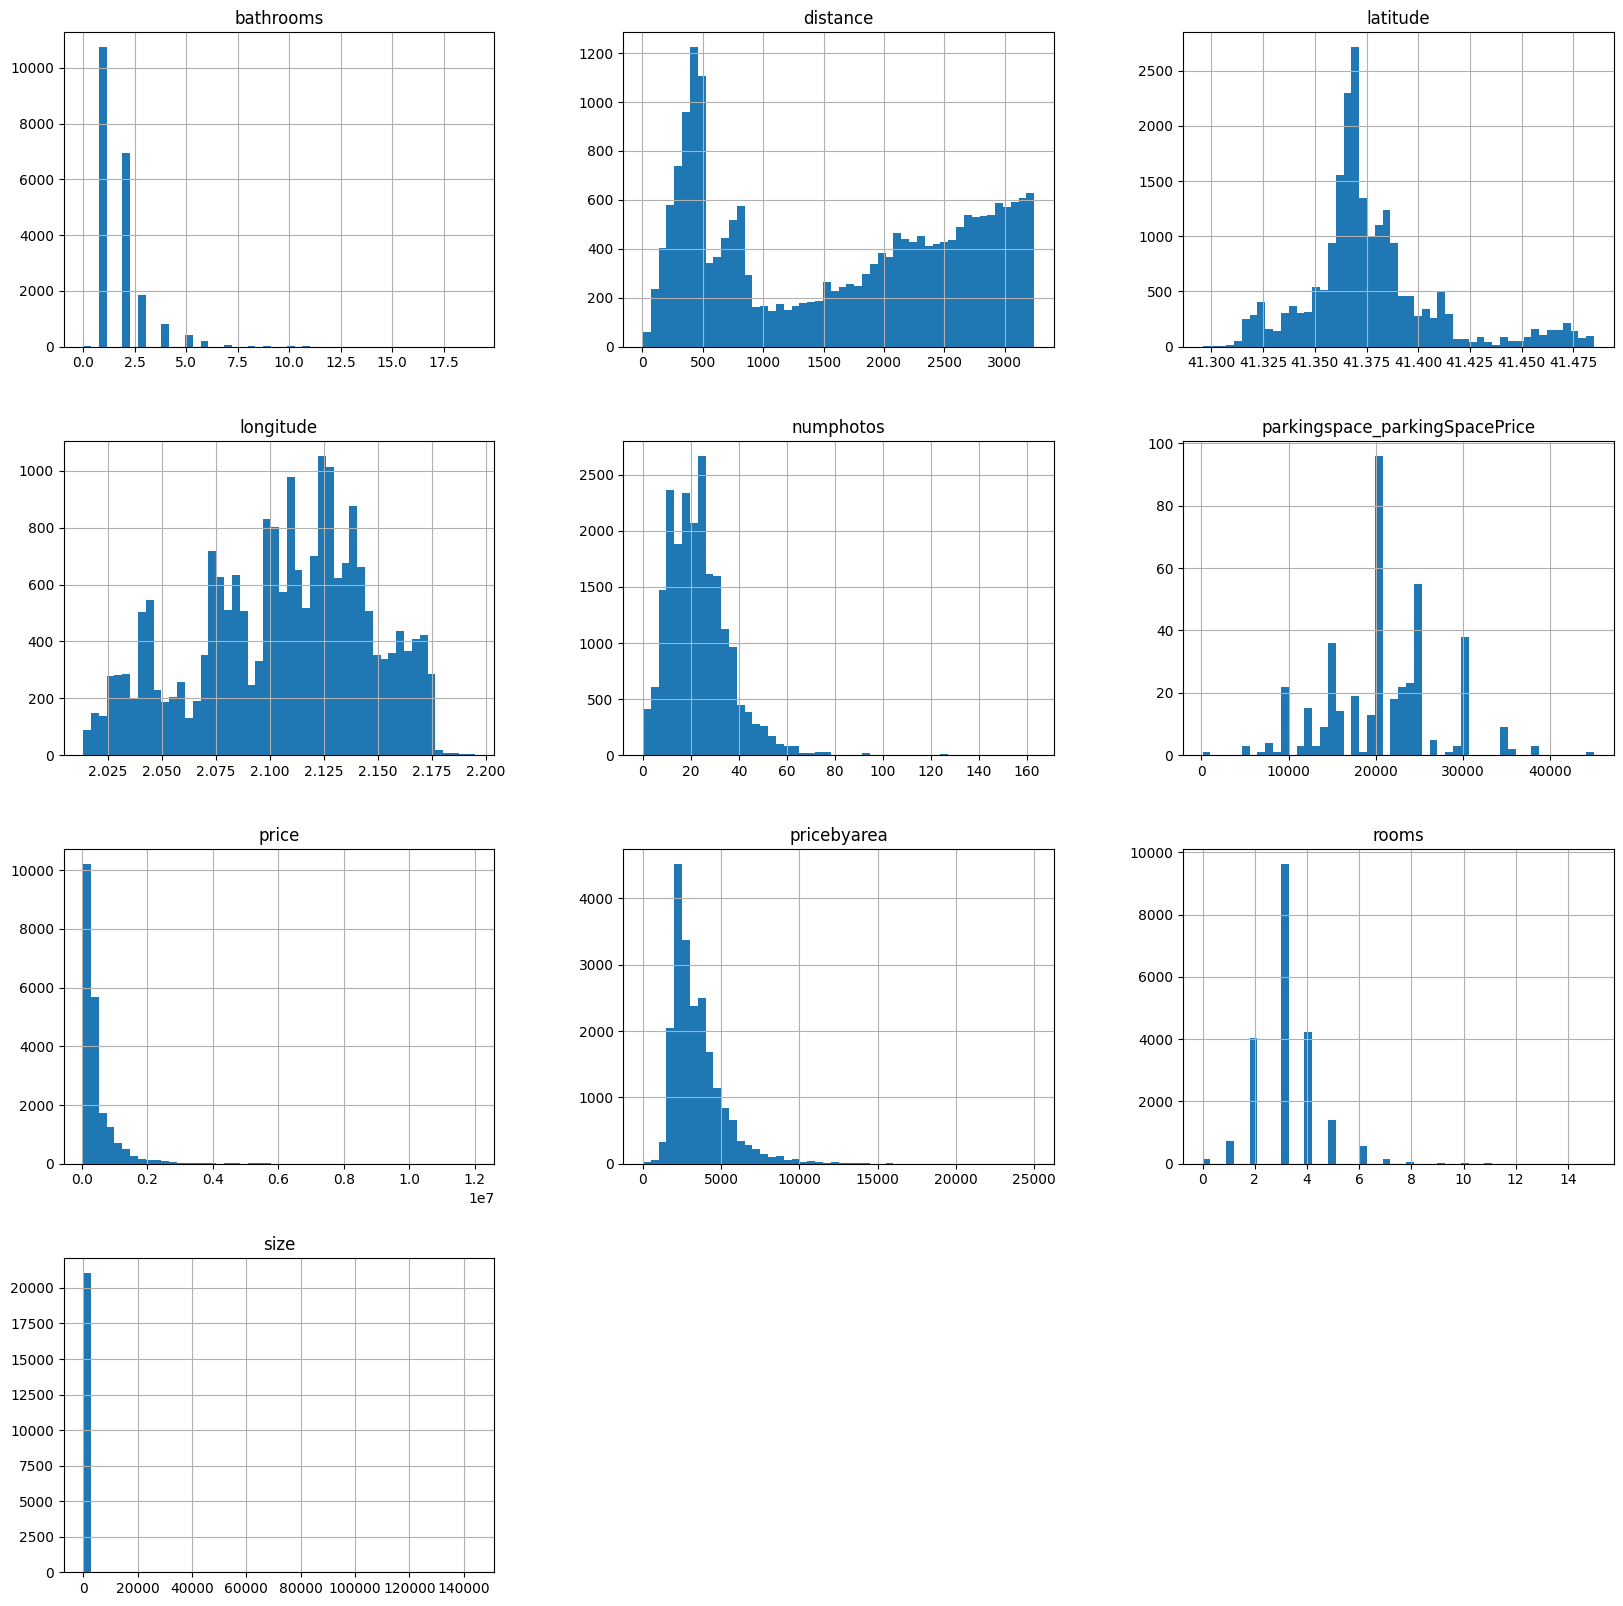

In [83]:
# plot the distribution of the continuous variables
idealista_pandas_df = idealista_df.toPandas()
idealista_pandas_df[continuous_variables].hist(bins=50, figsize=(20, 20))

In [68]:
idealista_df.printSchema()

root
 |-- address: string (nullable = true)
 |-- bathrooms: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- detailedtype_subTypology: string (nullable = true)
 |-- detailedtype_typology: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- district: string (nullable = true)
 |-- exterior: boolean (nullable = true)
 |-- externalreference: string (nullable = true)
 |-- floor: string (nullable = true)
 |-- has360: boolean (nullable = true)
 |-- has3dtour: boolean (nullable = true)
 |-- haslift: boolean (nullable = true)
 |-- hasplan: boolean (nullable = true)
 |-- hasstaging: boolean (nullable = true)
 |-- hasvideo: boolean (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- municipality: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- newdevelopment: boolean (nullable = true)
 |-- newdevelopmentfinished: boolean (nullable = true)
 |-- numphotos: integer (nullable = true)
 

In [69]:
idealista_df.show()

24/05/15 18:24:39 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/15 18:24:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


+--------------------+---------+-------+------------------------+---------------------+--------+--------------------+--------+------------------+-----+------+---------+-------+-------+----------+--------+----------+---------+--------------------+-------------+--------------+----------------------+---------+---------+----------------------------+------------------------------------------+------------------------------+--------+-----------+------------+------------+---------+-----+-----------+-----+--------------+-----------------------+--------------------+--------------------+-----------------+--------------------+----------+
|             address|bathrooms|country|detailedtype_subTypology|detailedtype_typology|distance|            district|exterior| externalreference|floor|has360|has3dtour|haslift|hasplan|hasstaging|hasvideo|  latitude|longitude|        municipality| neighborhood|newdevelopment|newdevelopmentfinished|numphotos|operation|parkingspace_hasParkingSpace|parkingspace_isPark

In [70]:
# from the distance column, print all values that are not integer like
idealista_df.filter(idealista_df['distance'].rlike('[^0-9]')).show()

24/05/15 18:24:50 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


+-------+---------+-------+------------------------+---------------------+--------+--------+--------+-----------------+-----+------+---------+-------+-------+----------+--------+--------+---------+------------+------------+--------------+----------------------+---------+---------+----------------------------+------------------------------------------+------------------------------+-----+-----------+------------+------------+--------+-----+-----------+----+------+-----------------------+--------------------+---------+-----------------+---+----+
|address|bathrooms|country|detailedtype_subTypology|detailedtype_typology|distance|district|exterior|externalreference|floor|has360|has3dtour|haslift|hasplan|hasstaging|hasvideo|latitude|longitude|municipality|neighborhood|newdevelopment|newdevelopmentfinished|numphotos|operation|parkingspace_hasParkingSpace|parkingspace_isParkingSpaceIncludedInPrice|parkingspace_parkingSpacePrice|price|pricebyarea|propertycode|propertytype|province|rooms|showadd

In [87]:
idealista_df = iqr_outlier_treatment(idealista_df, continuous_variables, factor=3)

24/05/15 18:43:16 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/15 18:43:23 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Column: bathrooms
Q1: 1.0
Q3: 2.0
IQR: 1.0
Lower Bound: -2.0
Upper Bound: 5.0


24/05/15 18:43:28 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/15 18:43:34 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


Number of outliers: 332
Outliers:


24/05/15 18:43:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/15 18:43:46 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


+--------------------+---------+-------+------------------------+---------------------+--------+-------------------+--------+-----------------+-----+------+---------+-------+-------+----------+--------+----------+---------+--------------------+--------------------+--------------+----------------------+---------+---------+----------------------------+------------------------------------------+------------------------------+---------+-----------+------------+------------+---------+-----+-----------+------+------+-----------------------+--------------------+--------------------+-----------------+--------------------+----------+
|             address|bathrooms|country|detailedtype_subTypology|detailedtype_typology|distance|           district|exterior|externalreference|floor|has360|has3dtour|haslift|hasplan|hasstaging|hasvideo|  latitude|longitude|        municipality|        neighborhood|newdevelopment|newdevelopmentfinished|numphotos|operation|parkingspace_hasParkingSpace|parkingspace_is

24/05/15 18:43:50 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/15 18:43:58 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Column: distance
Q1: 504.0
Q3: 2621.0
IQR: 2117.0
Lower Bound: -5847.0
Upper Bound: 8972.0


24/05/15 18:44:02 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


Number of outliers: 0


24/05/15 18:44:14 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/15 18:44:21 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Column: latitude
Q1: 41.3619074
Q3: 41.3857747
IQR: 0.023867299999999148
Lower Bound: 41.2903055
Upper Bound: 41.457376599999996


24/05/15 18:44:25 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/15 18:44:32 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


Number of outliers: 979
Outliers:


24/05/15 18:44:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/15 18:44:44 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


+--------------------+---------+-------+------------------------+---------------------+--------+----------------+--------+-----------------+-----+------+---------+-------+-------+----------+--------+----------+---------+--------------------+------------+--------------+----------------------+---------+---------+----------------------------+------------------------------------------+------------------------------+---------+-----------+------------+------------+---------+-----+-----------+------+------+-----------------------+--------------------+--------------------+-----------------+--------------------+----------+
|             address|bathrooms|country|detailedtype_subTypology|detailedtype_typology|distance|        district|exterior|externalreference|floor|has360|has3dtour|haslift|hasplan|hasstaging|hasvideo|  latitude|longitude|        municipality|neighborhood|newdevelopment|newdevelopmentfinished|numphotos|operation|parkingspace_hasParkingSpace|parkingspace_isParkingSpaceIncludedIn

24/05/15 18:44:48 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/15 18:44:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Column: longitude
Q1: 2.0780549
Q3: 2.1348477
IQR: 0.056792799999999755
Lower Bound: 1.9076765000000009
Upper Bound: 2.305226099999999


24/05/15 18:45:00 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


Number of outliers: 0


24/05/15 18:45:11 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/15 18:45:18 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Column: numphotos
Q1: 14.0
Q3: 30.0
IQR: 16.0
Lower Bound: -34.0
Upper Bound: 78.0


24/05/15 18:45:23 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/15 18:45:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


Number of outliers: 55
Outliers:


24/05/15 18:45:34 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/15 18:45:41 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


+--------------------+---------+-------+------------------------+---------------------+--------+--------------------+--------+-----------------+-----+------+---------+-------+-------+----------+--------+----------+---------+--------------------+--------------------+--------------+----------------------+---------+---------+----------------------------+------------------------------------------+------------------------------+---------+-----------+------------+------------+---------+-----+-----------+-----+------+-----------------------+--------------------+--------------------+-----------------+--------------------+----------+
|             address|bathrooms|country|detailedtype_subTypology|detailedtype_typology|distance|            district|exterior|externalreference|floor|has360|has3dtour|haslift|hasplan|hasstaging|hasvideo|  latitude|longitude|        municipality|        neighborhood|newdevelopment|newdevelopmentfinished|numphotos|operation|parkingspace_hasParkingSpace|parkingspace_i

24/05/15 18:45:45 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/15 18:45:52 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Column: parkingspace_parkingSpacePrice
Q1: 16000.0
Q3: 25000.0
IQR: 9000.0
Lower Bound: -11000.0
Upper Bound: 52000.0


24/05/15 18:45:56 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/15 18:46:01 WARN DAGScheduler: Broadcasting large task binary with size 1597.4 KiB


Number of outliers: 17672
Outliers:


24/05/15 18:46:05 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/15 18:46:09 WARN DAGScheduler: Broadcasting large task binary with size 1614.3 KiB


+--------------------+---------+-------+------------------------+---------------------+--------+--------------------+--------+------------------+-----+------+---------+-------+-------+----------+--------+----------+---------+--------------------+-------------+--------------+----------------------+---------+---------+----------------------------+------------------------------------------+------------------------------+--------+-----------+------------+------------+---------+-----+-----------+-----+--------------+-----------------------+--------------------+--------------------+-----------------+--------------------+----------+
|             address|bathrooms|country|detailedtype_subTypology|detailedtype_typology|distance|            district|exterior| externalreference|floor|has360|has3dtour|haslift|hasplan|hasstaging|hasvideo|  latitude|longitude|        municipality| neighborhood|newdevelopment|newdevelopmentfinished|numphotos|operation|parkingspace_hasParkingSpace|parkingspace_isPark

24/05/15 18:46:14 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/15 18:46:21 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Column: price
Q1: 170000.0
Q3: 495000.0
IQR: 325000.0
Lower Bound: -805000.0
Upper Bound: 1470000.0


24/05/15 18:46:26 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/15 18:46:33 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


Number of outliers: 1026
Outliers:


24/05/15 18:46:38 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/15 18:46:45 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


+--------------------+---------+-------+------------------------+---------------------+--------+-------------------+--------+-----------------+-----+------+---------+-------+-------+----------+--------+----------+---------+------------+--------------------+--------------+----------------------+---------+---------+----------------------------+------------------------------------------+------------------------------+---------+-----------+------------+------------+---------+-----+-----------+-----+------+-----------------------+--------------------+--------------------+-----------------+--------------------+----------+
|             address|bathrooms|country|detailedtype_subTypology|detailedtype_typology|distance|           district|exterior|externalreference|floor|has360|has3dtour|haslift|hasplan|hasstaging|hasvideo|  latitude|longitude|municipality|        neighborhood|newdevelopment|newdevelopmentfinished|numphotos|operation|parkingspace_hasParkingSpace|parkingspace_isParkingSpaceInclu

24/05/15 18:46:49 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/15 18:46:56 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Column: pricebyarea
Q1: 2315.0
Q3: 4119.0
IQR: 1804.0
Lower Bound: -3097.0
Upper Bound: 9531.0


24/05/15 18:47:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/15 18:47:08 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


Number of outliers: 251
Outliers:


24/05/15 18:47:13 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/15 18:47:20 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


+--------------------+---------+-------+------------------------+---------------------+--------+-------------------+--------+-----------------+-----+------+---------+-------+-------+----------+--------+----------+---------+------------+--------------------+--------------+----------------------+---------+---------+----------------------------+------------------------------------------+------------------------------+---------+-----------+------------+------------+---------+-----+-----------+-----+------+-----------------------+--------------------+--------------------+-----------------+--------------------+----------+
|             address|bathrooms|country|detailedtype_subTypology|detailedtype_typology|distance|           district|exterior|externalreference|floor|has360|has3dtour|haslift|hasplan|hasstaging|hasvideo|  latitude|longitude|municipality|        neighborhood|newdevelopment|newdevelopmentfinished|numphotos|operation|parkingspace_hasParkingSpace|parkingspace_isParkingSpaceInclu

24/05/15 18:47:24 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/15 18:47:31 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Column: rooms
Q1: 3.0
Q3: 4.0
IQR: 1.0
Lower Bound: 0.0
Upper Bound: 7.0


24/05/15 18:47:36 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/15 18:47:42 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


Number of outliers: 144
Outliers:


24/05/15 18:47:47 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/15 18:47:54 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


+--------------------+---------+-------+------------------------+---------------------+--------+--------------------+--------+-----------------+-----+------+---------+-------+-------+----------+--------+----------+---------+--------------------+--------------------+--------------+----------------------+---------+---------+----------------------------+------------------------------------------+------------------------------+---------+-----------+------------+------------+---------+-----+-----------+------+------+-----------------------+--------------------+--------------------+-----------------+--------------------+----------+
|             address|bathrooms|country|detailedtype_subTypology|detailedtype_typology|distance|            district|exterior|externalreference|floor|has360|has3dtour|haslift|hasplan|hasstaging|hasvideo|  latitude|longitude|        municipality|        neighborhood|newdevelopment|newdevelopmentfinished|numphotos|operation|parkingspace_hasParkingSpace|parkingspace_

24/05/15 18:47:58 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/15 18:48:06 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


Column: size
Q1: 67.0
Q3: 126.0
IQR: 59.0
Lower Bound: -110.0
Upper Bound: 303.0


24/05/15 18:48:10 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/15 18:48:17 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


Number of outliers: 1454
Outliers:


24/05/15 18:48:22 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
24/05/15 18:48:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


+--------------------+---------+-------+------------------------+---------------------+--------+--------------------+--------+-----------------+-----+------+---------+-------+-------+----------+--------+----------+---------+--------------------+--------------------+--------------+----------------------+---------+---------+----------------------------+------------------------------------------+------------------------------+---------+-----------+------------+------------+---------+-----+-----------+--------+------+-----------------------+--------------------+--------------------+-----------------+--------------------+----------+
|             address|bathrooms|country|detailedtype_subTypology|detailedtype_typology|distance|            district|exterior|externalreference|floor|has360|has3dtour|haslift|hasplan|hasstaging|hasvideo|  latitude|longitude|        municipality|        neighborhood|newdevelopment|newdevelopmentfinished|numphotos|operation|parkingspace_hasParkingSpace|parkingspac

Since we have a lot of columns removing univariate outliers is premature at this state, we leave it for later stages of the data management backbone.

In [88]:
idealista_df.write.format("mongodb") \
    .mode("overwrite") \
    .option("database", "bdm") \
    .option("collection", "idealista") \
    .save()

24/05/15 18:50:42 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/15 18:50:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


## Air quality

In [6]:
airquality_dir = "../data/persistent-landing-zone/opendatabcn/airquality"
# get files
files = os.listdir(airquality_dir)
# keep only those that start with a year (4 digits)
files = [file for file in files if file[:4].isdigit()]
months = [file[:7] for file in files]
# add the path to the files
files = [f"{airquality_dir}/{file}" for file in files]
# create a list of dataframes
airquality_dfs = {}
for file, month in zip(files, months):
    # read the file
    df = spark.read.format("avro").load(file)
    # append the dataframe to the list
    airquality_dfs[month] = df

In [7]:
len(airquality_dfs)

69

### Schema alignment

In [8]:
airquality_dfs['2018_06'].printSchema()

root
 |-- nom_cabina: string (nullable = true)
 |-- qualitat_aire: string (nullable = true)
 |-- codi_dtes: string (nullable = true)
 |-- zqa: integer (nullable = true)
 |-- codi_eoi: integer (nullable = true)
 |-- longitud: double (nullable = true)
 |-- latitud: double (nullable = true)
 |-- hora_o3: string (nullable = true)
 |-- qualitat_o3: string (nullable = true)
 |-- valor_o3: string (nullable = true)
 |-- hora_no2: string (nullable = true)
 |-- qualitat_no2: string (nullable = true)
 |-- valor_no2: string (nullable = true)
 |-- hora_pm10: string (nullable = true)
 |-- qualitat_pm10: string (nullable = true)
 |-- valor_pm10: string (nullable = true)
 |-- generat: string (nullable = true)
 |-- dateTime: integer (nullable = true)



In [9]:
# change all column names to lowercase
for month in airquality_dfs:
    df = airquality_dfs[month]
    for col in df.columns:
        df = df.withColumnRenamed(col, col.lower())
    airquality_dfs[month] = df

In [96]:
print_by_month = {}
for month in airquality_dfs:
    # print len of columns
    print_by_month[month] = len(airquality_dfs[month].columns)

# order by key
print_by_month = dict(sorted(print_by_month.items(), key=lambda item: item[0]))
for month in print_by_month:
    print(f"Month {month} has {print_by_month[month]} columns")

Month 2018_06 has 18 columns
Month 2018_07 has 18 columns
Month 2018_08 has 18 columns
Month 2018_09 has 18 columns
Month 2018_10 has 18 columns
Month 2018_11 has 18 columns
Month 2018_12 has 18 columns
Month 2019_01 has 18 columns
Month 2019_02 has 18 columns
Month 2019_03 has 18 columns
Month 2019_04 has 57 columns
Month 2019_05 has 57 columns
Month 2019_06 has 1 columns
Month 2019_07 has 1 columns
Month 2019_08 has 57 columns
Month 2019_09 has 57 columns
Month 2019_10 has 57 columns
Month 2019_11 has 57 columns
Month 2019_12 has 57 columns
Month 2020_01 has 57 columns
Month 2020_02 has 57 columns
Month 2020_03 has 57 columns
Month 2020_04 has 57 columns
Month 2020_05 has 57 columns
Month 2020_06 has 57 columns
Month 2020_07 has 57 columns
Month 2020_08 has 57 columns
Month 2020_09 has 57 columns
Month 2020_10 has 57 columns
Month 2020_11 has 57 columns
Month 2020_12 has 57 columns
Month 2021_01 has 57 columns
Month 2021_02 has 57 columns
Month 2021_03 has 57 columns
Month 2021_04 ha

In [13]:
airquality_dfs['2019_02'].show()

+--------------------+-------------+---------+---+--------+--------+-------+-------+-----------+----------+--------+------------+----------+---------+-------------+----------+---------------+----------+
|          nom_cabina|qualitat_aire|codi_dtes|zqa|codi_eoi|longitud|latitud|hora_o3|qualitat_o3|  valor_o3|hora_no2|qualitat_no2| valor_no2|hora_pm10|qualitat_pm10|valor_pm10|        generat|  datetime|
+--------------------+-------------+---------+---+--------+--------+-------+-------+-----------+----------+--------+------------+----------+---------+-------------+----------+---------------+----------+
|   Barcelona - Sants|           --|       ID|  1| 8019042|  2.1331|41.3788|   NULL|       NULL|      NULL|    NULL|        NULL|      NULL|     NULL|         NULL|      NULL|01/02/2019 0:00|1548975902|
|Barcelona - Eixample|           --|       IH|  1| 8019043|  2.1538|41.3853|   NULL|       NULL|      NULL|    NULL|        NULL|      NULL|      21h|           --|        --|01/02/2019 0:

In [11]:
# month smaller than or equal to 2019_03
airquality_dfs_old = {month: airquality_dfs[month] for month in airquality_dfs if month <= '2019_03'}
airquality_dfs_new = {month: airquality_dfs[month] for month in airquality_dfs if month > '2019_03'} 

In [12]:
print(f"Airquality dataframes before 2019_03: {len(airquality_dfs_old)}")
print(f"Airquality dataframes after 2019_03: {len(airquality_dfs_new)}")

Airquality dataframes before 2019_03: 10
Airquality dataframes after 2019_03: 59


#### Old

In [14]:
all_columns = set()
for month in airquality_dfs_old:
    # print nr of cols
    all_columns = all_columns.union(set(airquality_dfs_old[month].columns))
    # exclude nested fields as they have been flattened
    all_columns = all_columns
print(f"There are {len(all_columns)} unique columns in the dataframes")

There are 18 unique columns in the dataframes


In [16]:
from pyspark.sql.types import NullType, StringType, IntegerType, DoubleType, BooleanType

column_data_types = {}
for month in airquality_dfs_old:
    df = airquality_dfs_old[month]
    for column in df.columns:
        # if it has not been added and is not of Null type
        if column not in column_data_types and df.schema[column].dataType != NullType():
            column_data_types[column] = df.schema[column].dataType
column_data_types

{'nom_cabina': StringType(),
 'qualitat_aire': StringType(),
 'codi_dtes': StringType(),
 'zqa': IntegerType(),
 'codi_eoi': IntegerType(),
 'longitud': DoubleType(),
 'latitud': DoubleType(),
 'hora_o3': StringType(),
 'qualitat_o3': StringType(),
 'valor_o3': StringType(),
 'hora_no2': StringType(),
 'qualitat_no2': StringType(),
 'valor_no2': StringType(),
 'hora_pm10': StringType(),
 'qualitat_pm10': StringType(),
 'valor_pm10': StringType(),
 'generat': StringType(),
 'datetime': IntegerType()}

In [17]:
nr_of_incomplete_dfs = 0
frequently_missing_cols = set()
for month in airquality_dfs_old:
    df = airquality_dfs_old[month]
    missing_cols = all_columns - set(df.columns)
    frequently_missing_cols = frequently_missing_cols.union(missing_cols)
    if len(missing_cols) > 0:
        nr_of_incomplete_dfs += 1
        print(f"There are {len(missing_cols)} missing columns in the dataframe for month {month}, the columns are: {missing_cols}")

We are good here.

In [18]:
columns_with_datatype_counter = {}
for month in airquality_dfs_old:
    df = airquality_dfs_old[month]
    for column in df.columns:
        datatype = df.schema[column].dataType
        concat_column_datatype = f"{column} - {datatype}"
        if concat_column_datatype not in columns_with_datatype_counter:
            columns_with_datatype_counter[concat_column_datatype] = 1
        else:
            columns_with_datatype_counter[concat_column_datatype] += 1

In [20]:
# get entries where value is not 129 and 1
columns_needing_fix = {}
for col_and_type in columns_with_datatype_counter.keys():
    columns_needing_fix[col_and_type] = columns_with_datatype_counter[col_and_type]
columns_needing_fix = dict(sorted(columns_needing_fix.items(), key=lambda item: item[0], reverse=True))
columns_needing_fix

{'zqa - IntegerType()': 10,
 'valor_pm10 - StringType()': 10,
 'valor_o3 - StringType()': 9,
 'valor_o3 - DoubleType()': 1,
 'valor_no2 - StringType()': 9,
 'valor_no2 - DoubleType()': 1,
 'qualitat_pm10 - StringType()': 10,
 'qualitat_o3 - StringType()': 9,
 'qualitat_o3 - DoubleType()': 1,
 'qualitat_no2 - StringType()': 9,
 'qualitat_no2 - DoubleType()': 1,
 'qualitat_aire - StringType()': 10,
 'nom_cabina - StringType()': 10,
 'longitud - DoubleType()': 10,
 'latitud - DoubleType()': 10,
 'hora_pm10 - StringType()': 10,
 'hora_o3 - StringType()': 9,
 'hora_o3 - DoubleType()': 1,
 'hora_no2 - StringType()': 9,
 'hora_no2 - DoubleType()': 1,
 'generat - StringType()': 10,
 'datetime - IntegerType()': 10,
 'codi_eoi - IntegerType()': 10,
 'codi_dtes - StringType()': 10}

In [21]:
# get rid of null values by casting NullType to the column_data_types mapping
for month in airquality_dfs_old:
    df = airquality_dfs_old[month]
    for column in df.columns:
        # change data type to the correct one
        df = df.withColumn(column, df[column].cast(column_data_types[column]))
    airquality_dfs_old[month] = df

In [22]:
columns_with_datatype_counter = {}
for month in airquality_dfs_old:
    df = airquality_dfs_old[month]
    for column in df.columns:
        datatype = df.schema[column].dataType
        concat_column_datatype = f"{column} - {datatype}"
        if concat_column_datatype not in columns_with_datatype_counter:
            columns_with_datatype_counter[concat_column_datatype] = 1
        else:
            columns_with_datatype_counter[concat_column_datatype] += 1

In [23]:
# get entries where value is not 129 and 1
columns_needing_fix = {}
for col_and_type in columns_with_datatype_counter.keys():
    columns_needing_fix[col_and_type] = columns_with_datatype_counter[col_and_type]
columns_needing_fix = dict(sorted(columns_needing_fix.items(), key=lambda item: item[0], reverse=True))
columns_needing_fix

{'zqa - IntegerType()': 10,
 'valor_pm10 - StringType()': 10,
 'valor_o3 - StringType()': 10,
 'valor_no2 - StringType()': 10,
 'qualitat_pm10 - StringType()': 10,
 'qualitat_o3 - StringType()': 10,
 'qualitat_no2 - StringType()': 10,
 'qualitat_aire - StringType()': 10,
 'nom_cabina - StringType()': 10,
 'longitud - DoubleType()': 10,
 'latitud - DoubleType()': 10,
 'hora_pm10 - StringType()': 10,
 'hora_o3 - StringType()': 10,
 'hora_no2 - StringType()': 10,
 'generat - StringType()': 10,
 'datetime - IntegerType()': 10,
 'codi_eoi - IntegerType()': 10,
 'codi_dtes - StringType()': 10}

#### New

In [28]:
# drop entries that have one column dataframe
airquality_dfs_new = {month: airquality_dfs_new[month] for month in airquality_dfs_new if len(airquality_dfs_new[month].columns) > 1}

In [29]:
all_columns = set()
for month in airquality_dfs_new:
    # print nr of cols
    all_columns = all_columns.union(set(airquality_dfs_new[month].columns))
    # exclude nested fields as they have been flattened
    all_columns = all_columns
print(f"There are {len(all_columns)} unique columns in the dataframes")

There are 57 unique columns in the dataframes


In [30]:
from pyspark.sql.types import NullType, StringType, IntegerType, DoubleType, BooleanType

column_data_types = {}
for month in airquality_dfs_new:
    df = airquality_dfs_new[month]
    for column in df.columns:
        # if it has not been added and is not of Null type
        if column not in column_data_types and df.schema[column].dataType != NullType():
            column_data_types[column] = df.schema[column].dataType
column_data_types

{'codi_provincia': IntegerType(),
 'provincia': StringType(),
 'codi_municipi': IntegerType(),
 'municipi': StringType(),
 'estacio': IntegerType(),
 'codi_contaminant': IntegerType(),
 'any': IntegerType(),
 'mes': IntegerType(),
 'dia': IntegerType(),
 'h01': DoubleType(),
 'v01': StringType(),
 'h02': DoubleType(),
 'v02': StringType(),
 'h03': DoubleType(),
 'v03': StringType(),
 'h04': DoubleType(),
 'v04': StringType(),
 'h05': DoubleType(),
 'v05': StringType(),
 'h06': DoubleType(),
 'v06': StringType(),
 'h07': DoubleType(),
 'v07': StringType(),
 'h08': DoubleType(),
 'v08': StringType(),
 'h09': DoubleType(),
 'v09': StringType(),
 'h10': DoubleType(),
 'v10': StringType(),
 'h11': DoubleType(),
 'v11': StringType(),
 'h12': DoubleType(),
 'v12': StringType(),
 'h13': DoubleType(),
 'v13': StringType(),
 'h14': DoubleType(),
 'v14': StringType(),
 'h15': DoubleType(),
 'v15': StringType(),
 'h16': DoubleType(),
 'v16': StringType(),
 'h17': DoubleType(),
 'v17': StringType()

In [32]:
nr_of_incomplete_dfs = 0
frequently_missing_cols = set()
for month in airquality_dfs_new:
    df = airquality_dfs_new[month]
    missing_cols = all_columns - set(df.columns)
    frequently_missing_cols = frequently_missing_cols.union(missing_cols)
    if len(missing_cols) > 0:
        nr_of_incomplete_dfs += 1
        print(f"There are {len(missing_cols)} missing columns in the dataframe for month {month}, the columns are: {missing_cols}")

Equal number of columns.

In [33]:
columns_with_datatype_counter = {}
for month in airquality_dfs_old:
    df = airquality_dfs_old[month]
    for column in df.columns:
        datatype = df.schema[column].dataType
        concat_column_datatype = f"{column} - {datatype}"
        if concat_column_datatype not in columns_with_datatype_counter:
            columns_with_datatype_counter[concat_column_datatype] = 1
        else:
            columns_with_datatype_counter[concat_column_datatype] += 1

In [34]:
# get entries where value is not 129 and 1
columns_needing_fix = {}
for col_and_type in columns_with_datatype_counter.keys():
    columns_needing_fix[col_and_type] = columns_with_datatype_counter[col_and_type]
columns_needing_fix = dict(sorted(columns_needing_fix.items(), key=lambda item: item[0], reverse=True))
columns_needing_fix

{'zqa - IntegerType()': 10,
 'valor_pm10 - StringType()': 10,
 'valor_o3 - StringType()': 10,
 'valor_no2 - StringType()': 10,
 'qualitat_pm10 - StringType()': 10,
 'qualitat_o3 - StringType()': 10,
 'qualitat_no2 - StringType()': 10,
 'qualitat_aire - StringType()': 10,
 'nom_cabina - StringType()': 10,
 'longitud - DoubleType()': 10,
 'latitud - DoubleType()': 10,
 'hora_pm10 - StringType()': 10,
 'hora_o3 - StringType()': 10,
 'hora_no2 - StringType()': 10,
 'generat - StringType()': 10,
 'datetime - IntegerType()': 10,
 'codi_eoi - IntegerType()': 10,
 'codi_dtes - StringType()': 10}

Schema is aligned, we can merge.

In [37]:
# print the lens of old and new airquality dataframes
old_size = 0
new_size = 0
for month in airquality_dfs_old:
    old_size += airquality_dfs_old[month].count()
    print(f"Month {month} has {airquality_dfs_old[month].count()} rows")
for month in airquality_dfs_new:
    new_size += airquality_dfs_new[month].count()
    print(f"Month {month} has {airquality_dfs_new[month].count()} rows")

Month 2018_12 has 5848 rows
Month 2019_03 has 5928 rows
Month 2018_07 has 3649 rows
Month 2019_01 has 5904 rows
Month 2018_09 has 5736 rows
Month 2018_10 has 5944 rows
Month 2019_02 has 5376 rows
Month 2018_06 has 3262 rows
Month 2018_11 has 5744 rows
Month 2018_08 has 5800 rows
Month 2022_10 has 2015 rows
Month 2022_03 has 1987 rows
Month 2022_05 has 2015 rows
Month 2019_12 has 1276 rows
Month 2023_12 has 2015 rows
Month 2019_11 has 1215 rows
Month 2021_05 has 1674 rows
Month 2023_08 has 2015 rows
Month 2021_12 has 1705 rows
Month 2020_07 has 1519 rows
Month 2022_07 has 2015 rows
Month 2023_07 has 2039 rows
Month 2021_11 has 1587 rows
Month 2021_04 has 1480 rows
Month 2021_07 has 1674 rows
Month 2021_01 has 1519 rows
Month 2020_03 has 1395 rows
Month 2022_06 has 1950 rows
Month 2024_02 has 1856 rows
Month 2019_09 has 1131 rows
Month 2023_06 has 1980 rows
Month 2021_02 has 1372 rows
Month 2021_03 has 1519 rows
Month 2019_04 has 1131 rows
Month 2019_10 has 1209 rows
Month 2022_12 has 20

In [38]:
print(f"Old total rows: {old_size}")
print(f"New total rows: {new_size}")

Old total rows: 53191
New total rows: 95226


In [41]:
# add a column to each dataframe with the date
for month in airquality_dfs_new:
    df = airquality_dfs_new[month]
    df = df.withColumn('month', lit(month))
    airquality_dfs_new[month] = df
# merge all the dataframes into a single dataframe
airquality_df_new = None
for month in airquality_dfs_new:
    if airquality_df_new is None:
        airquality_df_new = airquality_dfs_new[month]
    else:
        airquality_df_new = airquality_df_new.union(airquality_dfs_new[month])
print(f"Number of rows in the new airquality dataframe: {airquality_df_new.count()}")

Number of rows in the new airquality dataframe: 95226


In [44]:
# add a column to each dataframe with the date
for month in airquality_dfs_old:
    df = airquality_dfs_old[month]
    df = df.withColumn('month', lit(month))
    airquality_dfs_old[month] = df
# merge all the dataframes into a single dataframe
airquality_df_old = None
for month in airquality_dfs_old:
    if airquality_df_old is None:
        airquality_df_old = airquality_dfs_old[month]
    else:
        airquality_df_old = airquality_df_old.union(airquality_dfs_old[month])
print(f"Number of rows in the old airquality dataframe: {airquality_df_old.count()}")

Number of rows in the old airquality dataframe: 53191


In [45]:
airquality_df_old.show(5)

+--------------------+-------------+---------+---+--------+--------+-------+-------+-----------+----------+--------+------------+----------+---------+-------------+----------+---------------+----------+-------+
|          nom_cabina|qualitat_aire|codi_dtes|zqa|codi_eoi|longitud|latitud|hora_o3|qualitat_o3|  valor_o3|hora_no2|qualitat_no2| valor_no2|hora_pm10|qualitat_pm10|valor_pm10|        generat|  datetime|  month|
+--------------------+-------------+---------+---+--------+--------+-------+-------+-----------+----------+--------+------------+----------+---------+-------------+----------+---------------+----------+-------+
|   Barcelona - Sants|         Bona|       ID|  1| 8019042|  2.1331|41.3788|   NULL|       NULL|      NULL|     23h|        Bona|39 Âµg/mÂ³|     NULL|         NULL|      NULL|01/12/2018 0:00|1543619102|2018_12|
|Barcelona - Eixample|         Bona|       IH|  1| 8019043|  2.1538|41.3853|   NULL|       NULL|      NULL|    NULL|        NULL|      NULL|      23h|      

In [46]:
airquality_df_new.show(5)

24/05/16 16:56:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+---------+-------------+---------+-------+----------------+----+---+---+----+---+---+---+---+---+---+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia| h01|v01|h02|v02|h03|v03|h04|v04| h05|v05| h06|v06| h07|v07| h08|v08| h09|v09| h10|v10| h11|v11| h12|v12|h13|v13|h14|v14|h15|v15|h16|v16|h17|v17|h18|v18|h19|v19|h20|v20|h21|v21|h22|v22|h23|v23|h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+----+---+---+---+---+---+---+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+-------+
|             8|Barcelona|           19|Barcelona|      4|               7|2022| 10|  1| 1.0|  V|1.0|  V|1

24/05/16 16:56:14 WARN DAGScheduler: Broadcasting large task binary with size 1699.3 KiB


### Deduplication

In [47]:
# airquality_df_old
print(f"Size before deduplication: {airquality_df_old.count()}")
airquality_df_old = airquality_df_old.dropDuplicates()
print(f"Size after deduplication: {airquality_df_old.count()}")

Size before deduplication: 53191


Size after deduplication: 53191


In [48]:
print(f"Size before deduplication: {airquality_df_new.count()}")
airquality_df_new = airquality_df_new.dropDuplicates()
print(f"Size after deduplication: {airquality_df_new.count()}")

Size before deduplication: 95226


24/05/16 16:58:34 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 16:58:40 WARN DAGScheduler: Broadcasting large task binary with size 1554.8 KiB


Size after deduplication: 95226


### Outlier detection

In [49]:
continuous_variables_old = detect_continuous_variables(airquality_df_old, 10)
print(continuous_variables_old)

/root/uni-projects/bdm2/.venv/lib/python3.10/site-packages/pyspark/sql/functions.py:3796: FutureWarning: Deprecated in 2.1, use approx_count_distinct instead.
  warnings.warn("Deprecated in 2.1, use approx_count_distinct instead.", FutureWarning)


['latitud', 'datetime']


In [53]:
airquality_df_old = iqr_outlier_treatment(airquality_df_old, continuous_variables_old, factor=3)

Column: latitud
Q1: 41.3864
Q3: 41.4039
IQR: 0.017499999999998295
Lower Bound: 41.33390000000001
Upper Bound: 41.456399999999995
Number of outliers: 192
Outliers:
+--------------------+-------------+---------+---+--------+--------+--------+-------+-----------+----------+--------+------------+----------+---------+-------------+----------+----------------+----------+-------+
|          nom_cabina|qualitat_aire|codi_dtes|zqa|codi_eoi|longitud| latitud|hora_o3|qualitat_o3|  valor_o3|hora_no2|qualitat_no2| valor_no2|hora_pm10|qualitat_pm10|valor_pm10|         generat|  datetime|  month|
+--------------------+-------------+---------+---+--------+--------+--------+-------+-----------+----------+--------+------------+----------+---------+-------------+----------+----------------+----------+-------+
|Barcelona - Vall ...|         Bona|       IN|  1| 8019054|   2.148|414261.0|     5h|       Bona|53 Âµg/mÂ³|      5h|        Bona|12 Âµg/mÂ³|       5h|         Bona|26 Âµg/mÂ³| 13/11/2018 6:00|15420

In [54]:
continuous_variables_new = detect_continuous_variables(airquality_df_new, 10)
print(continuous_variables_new)

/root/uni-projects/bdm2/.venv/lib/python3.10/site-packages/pyspark/sql/functions.py:3796: FutureWarning: Deprecated in 2.1, use approx_count_distinct instead.
  warnings.warn("Deprecated in 2.1, use approx_count_distinct instead.", FutureWarning)
24/05/16 17:01:27 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:01:32 WARN DAGScheduler: Broadcasting large task binary with size 1563.6 KiB
24/05/16 17:01:33 WARN DAGScheduler: Broadcasting large task binary with size 1521.9 KiB
24/05/16 17:01:35 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:01:40 WARN DAGScheduler: Broadcasting large task binary with size 1563.6 KiB
24/05/16 17:01:41 WARN DAGScheduler: Broadcasting large task binary with size 1521.9 KiB
24/05/16 17:01:43 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:01:48 WARN DAGScheduler: Broadcasting large task binary with size 1563.6 KiB
24/05/16 17:01:49 WARN DAGScheduler: Broadcasting 

['codi_contaminant', 'mes', 'dia', 'h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']


24/05/16 17:05:30 WARN DAGScheduler: Broadcasting large task binary with size 1521.9 KiB


In [55]:
airquality_df_new = iqr_outlier_treatment(airquality_df_new, continuous_variables_new, factor=3)

24/05/16 17:05:47 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:05:51 WARN DAGScheduler: Broadcasting large task binary with size 1508.9 KiB


Column: codi_contaminant
Q1: 7.0
Q3: 14.0
IQR: 7.0
Lower Bound: -14.0
Upper Bound: 35.0


24/05/16 17:05:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:05:58 WARN DAGScheduler: Broadcasting large task binary with size 1600.6 KiB


Number of outliers: 17044
Outliers:


24/05/16 17:06:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:06:04 WARN DAGScheduler: Broadcasting large task binary with size 1625.1 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:06:07 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:06:11 WARN DAGScheduler: Broadcasting large task binary with size 1508.9 KiB


Column: mes
Q1: 4.0
Q3: 10.0
IQR: 6.0
Lower Bound: -14.0
Upper Bound: 28.0


24/05/16 17:06:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


Number of outliers: 0


24/05/16 17:06:19 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:06:23 WARN DAGScheduler: Broadcasting large task binary with size 1508.9 KiB


Column: dia
Q1: 8.0
Q3: 23.0
IQR: 15.0
Lower Bound: -37.0
Upper Bound: 68.0


24/05/16 17:06:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


Number of outliers: 0


24/05/16 17:06:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:06:36 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h01
Q1: 2.0
Q3: 40.0
IQR: 38.0
Lower Bound: -112.0
Upper Bound: 154.0


24/05/16 17:06:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:06:42 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 12400
Outliers:


24/05/16 17:06:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:06:49 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:06:52 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:06:56 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h02
Q1: 1.99
Q3: 39.0
IQR: 37.01
Lower Bound: -109.04
Upper Bound: 150.03


24/05/16 17:06:59 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:07:02 WARN DAGScheduler: Broadcasting large task binary with size 1596.8 KiB


Number of outliers: 12517
Outliers:


24/05/16 17:07:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:07:09 WARN DAGScheduler: Broadcasting large task binary with size 1621.3 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:07:12 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:07:16 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h03
Q1: 2.0
Q3: 37.0
IQR: 35.0
Lower Bound: -103.0
Upper Bound: 142.0


24/05/16 17:07:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:07:22 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 12273
Outliers:


24/05/16 17:07:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:07:28 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:07:31 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h04
Q1: 2.0
Q3: 35.0
IQR: 33.0
Lower Bound: -97.0
Upper Bound: 134.0


24/05/16 17:07:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:07:42 WARN DAGScheduler: Broadcasting large task binary with size 1596.5 KiB


Number of outliers: 12023
Outliers:


24/05/16 17:07:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:07:48 WARN DAGScheduler: Broadcasting large task binary with size 1620.9 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:07:51 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:07:56 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h05
Q1: 1.0
Q3: 33.0
IQR: 32.0
Lower Bound: -95.0
Upper Bound: 129.0


24/05/16 17:07:59 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1596.5 KiB


Number of outliers: 12009
Outliers:


24/05/16 17:08:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:08:08 WARN DAGScheduler: Broadcasting large task binary with size 1620.9 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:08:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:08:15 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h06
Q1: 2.0
Q3: 33.0
IQR: 31.0
Lower Bound: -91.0
Upper Bound: 126.0


24/05/16 17:08:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:08:21 WARN DAGScheduler: Broadcasting large task binary with size 1596.5 KiB


Number of outliers: 12057
Outliers:


24/05/16 17:08:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:08:27 WARN DAGScheduler: Broadcasting large task binary with size 1620.9 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:08:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:08:35 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h07
Q1: 2.0
Q3: 38.0
IQR: 36.0
Lower Bound: -106.0
Upper Bound: 146.0


24/05/16 17:08:37 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:08:41 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 12076
Outliers:


24/05/16 17:08:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:08:47 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:08:50 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:08:54 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h08
Q1: 2.29
Q3: 48.0
IQR: 45.71
Lower Bound: -134.84
Upper Bound: 185.13


24/05/16 17:08:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:09:00 WARN DAGScheduler: Broadcasting large task binary with size 1596.8 KiB


Number of outliers: 12296
Outliers:


24/05/16 17:09:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:09:06 WARN DAGScheduler: Broadcasting large task binary with size 1621.3 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:09:09 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:09:14 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h09
Q1: 3.0
Q3: 54.0
IQR: 51.0
Lower Bound: -150.0
Upper Bound: 207.0


24/05/16 17:09:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 12801
Outliers:


24/05/16 17:09:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:09:26 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:09:29 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:09:33 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h10
Q1: 4.0
Q3: 54.0
IQR: 50.0
Lower Bound: -146.0
Upper Bound: 204.0


24/05/16 17:09:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:09:39 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 13683
Outliers:


24/05/16 17:09:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:09:46 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:09:49 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:09:53 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h11
Q1: 4.0
Q3: 50.0
IQR: 46.0
Lower Bound: -134.0
Upper Bound: 188.0


24/05/16 17:09:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:09:59 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 15094
Outliers:


24/05/16 17:10:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:10:05 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:10:08 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:10:12 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h12
Q1: 4.0
Q3: 48.0
IQR: 44.0
Lower Bound: -128.0
Upper Bound: 180.0


24/05/16 17:10:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:10:18 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 15122
Outliers:


24/05/16 17:10:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:10:24 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:10:27 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:10:31 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h13
Q1: 3.17
Q3: 48.0
IQR: 44.83
Lower Bound: -131.32000000000002
Upper Bound: 182.49


24/05/16 17:10:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1598.1 KiB


Number of outliers: 14831
Outliers:


24/05/16 17:10:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:10:43 WARN DAGScheduler: Broadcasting large task binary with size 1622.6 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:10:46 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:10:50 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h14
Q1: 3.0
Q3: 44.0
IQR: 41.0
Lower Bound: -120.0
Upper Bound: 167.0


24/05/16 17:10:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:10:57 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 14204
Outliers:


24/05/16 17:11:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:11:03 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:11:05 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:11:09 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h15
Q1: 3.0
Q3: 42.0
IQR: 39.0
Lower Bound: -114.0
Upper Bound: 159.0


24/05/16 17:11:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:11:16 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 13575
Outliers:


24/05/16 17:11:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:11:22 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:11:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h16
Q1: 3.0
Q3: 40.0
IQR: 37.0
Lower Bound: -108.0
Upper Bound: 151.0


24/05/16 17:11:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:11:35 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 13005
Outliers:


24/05/16 17:11:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:11:42 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:11:44 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:11:49 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h17
Q1: 2.0
Q3: 44.0
IQR: 42.0
Lower Bound: -124.0
Upper Bound: 170.0


24/05/16 17:11:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:11:55 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 11936
Outliers:


24/05/16 17:11:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:12:01 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:12:04 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:12:09 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h18
Q1: 2.0
Q3: 47.0
IQR: 45.0
Lower Bound: -133.0
Upper Bound: 182.0


24/05/16 17:12:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:12:15 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 11869
Outliers:


24/05/16 17:12:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:12:21 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:12:24 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:12:28 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h19
Q1: 2.0
Q3: 48.0
IQR: 46.0
Lower Bound: -136.0
Upper Bound: 186.0


24/05/16 17:12:31 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:12:34 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 11919
Outliers:


24/05/16 17:12:37 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:12:41 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:12:43 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:12:48 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h20
Q1: 2.0
Q3: 49.0
IQR: 47.0
Lower Bound: -139.0
Upper Bound: 190.0


24/05/16 17:12:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:12:54 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 11958
Outliers:


24/05/16 17:12:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:13:00 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:13:03 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:13:07 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h21
Q1: 2.0
Q3: 48.0
IQR: 46.0
Lower Bound: -136.0
Upper Bound: 186.0


24/05/16 17:13:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:13:13 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 12244
Outliers:


24/05/16 17:13:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:13:20 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:13:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:13:26 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h22
Q1: 2.0
Q3: 49.0
IQR: 47.0
Lower Bound: -139.0
Upper Bound: 190.0


24/05/16 17:13:29 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:13:33 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 12405
Outliers:


24/05/16 17:13:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:13:39 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:13:42 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:13:46 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h23
Q1: 2.0
Q3: 45.0
IQR: 43.0
Lower Bound: -127.0
Upper Bound: 174.0


24/05/16 17:13:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:13:53 WARN DAGScheduler: Broadcasting large task binary with size 1596.6 KiB


Number of outliers: 13002
Outliers:


24/05/16 17:13:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:13:59 WARN DAGScheduler: Broadcasting large task binary with size 1621.0 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

24/05/16 17:14:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:14:06 WARN DAGScheduler: Broadcasting large task binary with size 1507.6 KiB


Column: h24
Q1: 2.0
Q3: 44.53
IQR: 42.53
Lower Bound: -125.59
Upper Bound: 172.12


24/05/16 17:14:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:14:13 WARN DAGScheduler: Broadcasting large task binary with size 1596.8 KiB


Number of outliers: 30754
Outliers:


24/05/16 17:14:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/16 17:14:19 WARN DAGScheduler: Broadcasting large task binary with size 1621.3 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|   h03|v03|   h04|v04|   h05|v05|   h06|v06|   h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|   h14|v14|   h15|v15|   h16|v16|   h17|v17|   h18|v18|   h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+------+---+---

In [58]:
airquality_df_old.show(10)

+--------------------+-------------+---------+---+--------+--------+-------+-------+-----------+----------+--------+------------+----------+---------+-------------+----------+----------------+----------+-------+
|          nom_cabina|qualitat_aire|codi_dtes|zqa|codi_eoi|longitud|latitud|hora_o3|qualitat_o3|  valor_o3|hora_no2|qualitat_no2| valor_no2|hora_pm10|qualitat_pm10|valor_pm10|         generat|  datetime|  month|
+--------------------+-------------+---------+---+--------+--------+-------+-------+-----------+----------+--------+------------+----------+---------+-------------+----------+----------------+----------+-------+
|Barcelona - Eixample|         Bona|       IH|  1| 8019043|  2.1538|41.3853|    17h|       Bona|28 Âµg/mÂ³|     17h|        Bona|51 Âµg/mÂ³|      17h|         Bona|15 Âµg/mÂ³|02/12/2018 18:00|1543770302|2018_12|
|Barcelona - Obser...|         Bona|       OF|  1| 8019058|  2.1239|41.4183|    22h|       Bona| 8 Âµg/mÂ³|     22h|        Bona|22 Âµg/mÂ³|      22h|  

In [62]:
airquality_df_new.show(10)

24/05/16 17:50:56 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:51:01 WARN DAGScheduler: Broadcasting large task binary with size 1579.2 KiB


+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+-----+---+-----+---+-----+---+-----+---+-----+---+------+---+------+---+------+---+------+---+------+---+------+---+-----+---+-----+---+-----+---+-----+---+-----+---+-----+---+------+---+------+---+------+---+------+---+------+---+-------+
|codi_provincia|provincia|codi_municipi| municipi|estacio|codi_contaminant| any|mes|dia|   h01|v01|   h02|v02|  h03|v03|  h04|v04|  h05|v05|  h06|v06|  h07|v07|   h08|v08|   h09|v09|   h10|v10|   h11|v11|   h12|v12|   h13|v13|  h14|v14|  h15|v15|  h16|v16|  h17|v17|  h18|v18|  h19|v19|   h20|v20|   h21|v21|   h22|v22|   h23|v23|   h24|v24|  month|
+--------------+---------+-------------+---------+-------+----------------+----+---+---+------+---+------+---+-----+---+-----+---+-----+---+-----+---+-----+---+------+---+------+---+------+---+------+---+------+---+------+---+-----+---+-----+---+-----+---+-----+---+-----+---+-----+---+------+---+---

In [61]:
write_config = {
    "writeConcern.w": "majority",
    "replaceDocument": "false",
    "idFieldList": "codi_eoi,codi_dtes,datetime",  # Specify the field to use for upsert
    "operationType": "update",  # Specify the update operation
    "upsertDocument": "true"  # Enable upsert logic
}

airquality_df_old.write.format("mongodb") \
    .mode("append") \
    .option("database", "bdm") \
    .option("collection", "airquality_old") \
    .options(**write_config) \
    .save()

24/05/16 17:26:21 WARN CaseInsensitiveStringMap: Converting duplicated key idfieldlist into CaseInsensitiveStringMap.
24/05/16 17:26:21 WARN CaseInsensitiveStringMap: Converting duplicated key upsertDocument into CaseInsensitiveStringMap.
24/05/16 17:26:21 WARN CaseInsensitiveStringMap: Converting duplicated key replaceDocument into CaseInsensitiveStringMap.
24/05/16 17:26:21 WARN CaseInsensitiveStringMap: Converting duplicated key operationType into CaseInsensitiveStringMap.
24/05/16 17:26:21 WARN CaseInsensitiveStringMap: Converting duplicated key writeConcern.w into CaseInsensitiveStringMap.


In [63]:
write_config = {
    "writeConcern.w": "majority",
    "replaceDocument": "false",
    "idFieldList": "codi_provincia,codi_municipi,estacio,codi_contaminant,month,dia",  # Specify the field to use for upsert
    "operationType": "update",  # Specify the update operation
    "upsertDocument": "true"  # Enable upsert logic
}

airquality_df_new.write.format("mongodb") \
    .mode("append") \
    .option("database", "bdm") \
    .option("collection", "airquality") \
    .options(**write_config) \
    .save()

24/05/16 17:52:10 WARN CaseInsensitiveStringMap: Converting duplicated key idfieldlist into CaseInsensitiveStringMap.
24/05/16 17:52:10 WARN CaseInsensitiveStringMap: Converting duplicated key upsertDocument into CaseInsensitiveStringMap.
24/05/16 17:52:10 WARN CaseInsensitiveStringMap: Converting duplicated key replaceDocument into CaseInsensitiveStringMap.
24/05/16 17:52:10 WARN CaseInsensitiveStringMap: Converting duplicated key operationType into CaseInsensitiveStringMap.
24/05/16 17:52:10 WARN CaseInsensitiveStringMap: Converting duplicated key writeConcern.w into CaseInsensitiveStringMap.
24/05/16 17:52:12 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/16 17:52:16 WARN DAGScheduler: Broadcasting large task binary with size 1574.3 KiB


24/05/16 19:43:32 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 3004339 ms exceeds timeout 120000 ms
24/05/16 19:43:32 WARN SparkContext: Killing executors is not supported by current scheduler.
24/05/16 19:43:35 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$